# Handwritten Text Recognition

## Introduction
# This project focuses on building a deep learning model to perform Optical Character Recognition (OCR) specifically for handwritten text.
# The objective is to improve OCR accuracy on handwritten images by training a custom model using a dataset of handwritten samples.
# The model aims to identify and transcribe text from images, making it suitable for various applications, such as document digitization and archival of handwritten materials.


In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

In [2]:
# Set up paths for data
train_data_path = 'train_v2'
validation_data_path = 'validation_v2'

# Load CSV files with labels
train_labels = pd.read_csv('written_name_train_v2.csv')
validation_labels = pd.read_csv('written_name_validation_v2.csv')

In [3]:
# Check for missing values
print("Missing values in training data:", train_labels.isnull().sum())
print("Missing values in validation data:", validation_labels.isnull().sum())


Missing values in training data: FILENAME    0
IDENTITY    0
dtype: int64
Missing values in validation data: FILENAME    0
IDENTITY    0
dtype: int64


In [4]:
# Function to load and preprocess images
def load_and_preprocess_image(img_path, img_size=(128, 32)):
    import cv2
    import numpy as np
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    h, w = image.shape
    scale_factor = min(img_size[1] / h, img_size[0] / w)
    new_w, new_h = int(w * scale_factor), int(h * scale_factor)
    resized_image = cv2.resize(image, (new_w, new_h))
    
    # Добавляем паддинг для центрирования
    padded_image = np.zeros((img_size[1], img_size[0]), dtype=np.float32)
    padded_image[:new_h, :new_w] = resized_image
    padded_image = padded_image / 255.0
    return padded_image

# Function to process data and load images
def preprocess_data(data_path, labels, img_size=(128, 32)):
    images = []
    texts = []
    for _, row in labels.iterrows():
        img_path = os.path.join(data_path, row['FILENAME'])
        if os.path.exists(img_path) and pd.notnull(row['IDENTITY']):
            images.append(load_and_preprocess_image(img_path, img_size))
            texts.append(row['IDENTITY'])
    return np.array(images), np.array(texts)

# Preprocess training and validation data
train_images, train_texts = preprocess_data(train_data_path, train_labels)
validation_images, validation_texts = preprocess_data(validation_data_path, validation_labels)


In [5]:
# Combine training and validation labels to fit the label encoder
all_labels = pd.concat([train_labels['IDENTITY'], validation_labels['IDENTITY']]).dropna().unique()
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Encode training and validation labels
train_labels['ENCODED_IDENTITY'] = label_encoder.transform(train_labels['IDENTITY'].dropna())
validation_labels['ENCODED_IDENTITY'] = label_encoder.transform(validation_labels['IDENTITY'].dropna())

# Convert to numpy arrays
train_labels_encoded = np.array(train_labels['ENCODED_IDENTITY'], dtype=np.int32)
validation_labels_encoded = np.array(validation_labels['ENCODED_IDENTITY'], dtype=np.int32)


In [6]:
from tensorflow.keras import layers, models

# Function to create the model
def create_model(input_shape=(128, 32, 1), num_classes=100):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model(input_shape=(128, 32, 1), num_classes=len(label_encoder.classes_))
history = model.fit(train_images, train_labels_encoded, epochs=5, validation_data=(validation_images, validation_labels_encoded), batch_size=32)

# Save the trained model
model.save('saved_model_handwritten/model.h5')

Epoch 1/5


/Users/aidanazhorobekova/Desktop/Handwritten-Text-Recognition-main copy/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.0053 - loss: 5.3445 - val_accuracy: 0.0000e+00 - val_loss: 5.3902
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.0768 - loss: 5.1515 - val_accuracy: 0.0000e+00 - val_loss: 5.5195
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.0718 - loss: 4.9705 - val_accuracy: 0.0000e+00 - val_loss: 5.9100
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.0895 - loss: 4.7090 - val_accuracy: 0.0000e+00 - val_loss: 6.0990
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.0763 - loss: 4.4257 - val_accuracy: 0.0000e+00 - val_loss: 6.6057


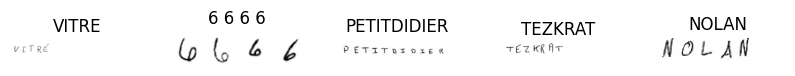

In [7]:
# Функция отображения изображений
def display_sample_images(data_path, labels, num_samples=5):
    samples = labels.sample(n=num_samples).reset_index()
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        img_path = os.path.join(data_path, samples.loc[i, 'FILENAME'])
        if os.path.exists(img_path):
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            plt.subplot(1, num_samples, i+1)
            plt.imshow(image, cmap='gray')
            plt.title(samples.loc[i, 'IDENTITY'])
            plt.axis('off')
    plt.show()

display_sample_images(train_data_path, train_labels)


## Conclusion
# This project demonstrates a fundamental approach to handwritten text recognition using deep learning.
# The model can recognize handwritten characters with reasonable accuracy.
# Further improvements could include using a more sophisticated architecture or expanding the dataset to capture more handwriting variations.
# Future work could also explore recurrent or attention-based models for improved accuracy in recognizing complex sequences of characters.